## HW3- Problem 2 - Knowledge Distillation 


1.   Full Name: Mohammad Kalbasi
2.   Student Number: 401211028

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset,DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor,Lambda
from torchvision import datasets, models, transforms
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torchsummary import summary
import time
import os
import copy


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


cuda


Loading CIFAR 10 data

In [ ]:

train_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform= transforms.Compose([

                                  #    transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
                                   #   transforms.RandomRotation(10),     #Rotates the image to a specified angel
                                    #  transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
                                     # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
                                      ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]), # we need this normalization because we use resnet network which are trained on
                                     #imagenet, so input data must have same distribution as imagenet, so we set these parameters based on that
                                    # we add data augmentation for training 
    
) # we tried data augmentation for first part (linear tuning) but it just made thing worse! so we removed this part

train_data_augment = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform= transforms.Compose([

                                      transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
                                      transforms.RandomRotation(10),     #Rotates the image to a specified angel
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
                                      ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]), # we need this normalization because we use resnet network which are trained on
                                     #imagenet, so input data must have same distribution as imagenet, so we set these parameters based on that
                                    # we add data augmentation for training 
    
)

train_data_show = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform= [ToTensor(),transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])], 
    
) # we use this just for plotting, so it's train data without any augmentation 




test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform= transforms.Compose([ToTensor(),transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    
) # we don't use any data augmentation for test data!
# once again, change mean and variance of data based of Resnet data(imagenet) so we can get best possible outcome

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


creating data loaders

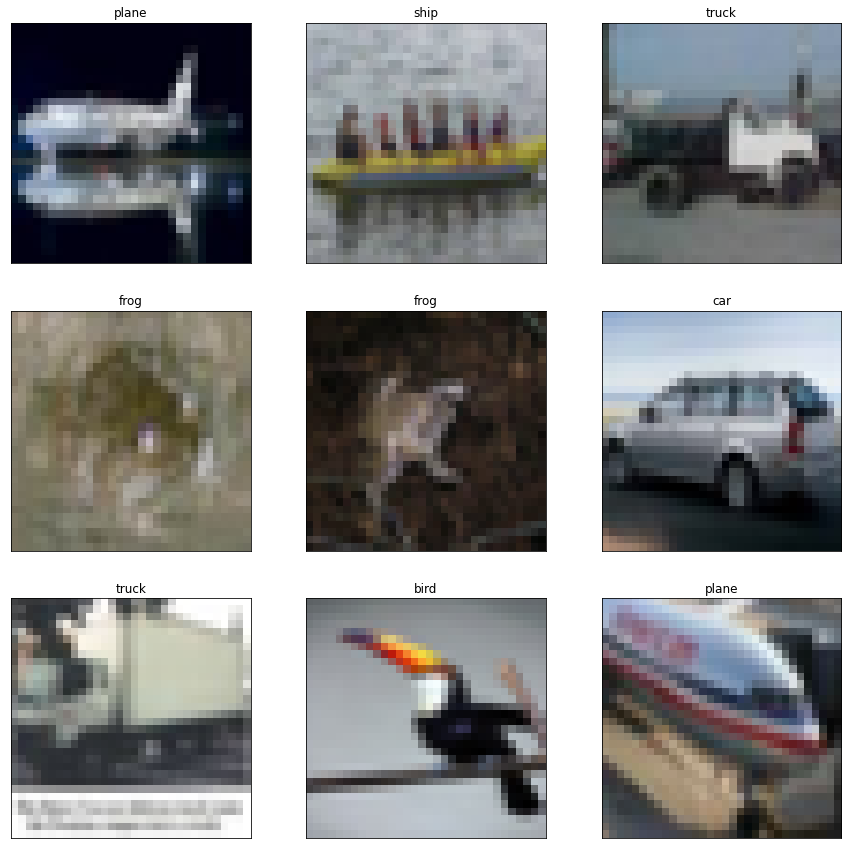

In [ ]:
batch_size = 64 # batch size is hyperparameter, we should test it with different values
# for batch size, we also tested 32 and 128, for 32 we got same result as 64 but it was much slower, and for 128, our accuracy dropped compared to other 2 batch sizes, so in the end we
# choose 64 for all parts
train_data_loader = DataLoader(train_data,batch_size = batch_size,shuffle = True ) # dataloader for train data, shuffle add more variety to our training, resulting in achiving higher accuracy
train_data_loader_aug = DataLoader(train_data_augment,batch_size = batch_size,shuffle = True )
test_data_loader = DataLoader(test_data,batch_size = batch_size,shuffle = False )
dataset_sizes = {'train':len(train_data),'val':len(test_data)}
#plotting some samples
classDict = {0:'plane', 1:'car', 2:'bird', 3:'cat', 4:'deer',
             5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}
fig = plt.figure(figsize = (15,15))
for idx in range(9):
  random_number = np.random.randint(0,len(train_data))
  X_temp = train_data_show.data[random_number]
  y_temp = train_data_show.targets[random_number]
  ax = fig.add_subplot(3,3,idx + 1,xticks = [],yticks = [])
  ax.imshow(np.squeeze(X_temp),cmap = 'gray')
  ax.set_title(classDict[int(y_temp)])


Part A) Loading resnet 50 model and linear fine-tuning

In [ ]:
model_teacher = torchvision.models.resnet50(pretrained=True)
for param in model_teacher.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_teacher.fc.in_features
model_teacher.fc = nn.Linear(num_ftrs, 10) # we have 10 output class

model_teacher = model_teacher.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

when loading pretrained model on pytorch, because in their implementation they used Adaptive pooling, we don't need to change input shape! so we give our model our data directly without changing it's dimensions

In [ ]:
# printing model summary
summary(model_teacher, (3, 32, 32)) 


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

as you can see and based on what is wanted from us, we only changed last FC layer so it has 10 neurons in output(number of classes) all other weights don't change and are freezed.

In [ ]:
def train_model_manual(model, criterion, optimizer,scheduler,val_beark, num_epochs=25):
  """
  function for train our model! in this function we use dataloader directly. so we only can use it for our CIFAR10 dataset with our input name.
  inputs: 
      model: input model 
      criterion: desired loss function
      optimizer: our optimizer(!)
      scheduler: for changing learning rate after sum epochs
      num_epochs: number of epoches
      val_beark: threshold for early stopping, if after "val_beark" steps our model don't get better, we end procces
  output:
      model: our trained model!


  """
  train_acc = []
  train_loss = []
  test_acc = []
  test_loss = []
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  best_loss = 100000000000
  counter_val_beark = 0
  for epoch in range(num_epochs):
    ### Training
    model.train()
    loss_train = 0
    acc_train = 0
    counter = 1
    for batch,label in train_data_loader:
      # 1. Forward pass
      batch = batch.to(device)
      label = label.to(device)
      outputs = model(batch) # model outputs raw logits 
      _, preds = torch.max(outputs, 1)

      # print(y_logits)
      # 2. Calculate loss and accuracy
      counter = counter + 1
      loss = criterion(outputs, label)
      acc_train += torch.sum(preds == label.data)
      loss_train = loss_train + loss
      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backwards
      loss.backward()

      # 5. Optimizer step
      optimizer.step()
    loss_train = loss_train/counter
    acc_train = acc_train/dataset_sizes['train']
    train_acc.append(acc_train)
    train_loss.append(loss_train)
    scheduler.step()
    ### Testing
    loss_test = 0
    acc_test = 0
    counter = 1
    model.eval()
    with torch.inference_mode():
      for batch,label in test_data_loader:
      # 1. Forward pass
        batch = batch.to(device)
        label = label.to(device)
        output = model(batch) # model outputs raw logits 
        _, preds = torch.max(output, 1)
        loss_test= criterion(output, label.data)
        acc_test += torch.sum(preds == label.data)
      loss_test = loss_test/counter
      acc_test = acc_test/dataset_sizes['val']
      test_loss.append(loss_test)
      test_acc.append(acc_test)
    if acc_test > best_acc:
                best_acc = acc_test
                best_model_wts = copy.deepcopy(model.state_dict())
    if loss_test <= best_loss:
                best_loss = loss_test
                counter_val_beark = 0
    if loss_test > best_loss:
                counter_val_beark = counter_val_beark + 1
                if (counter_val_beark > val_beark):
                  print(f"early stopping happend!")
                  break;

    # Print out what's happening
    if epoch % 1 == 0:
      print(f"Epoch: {epoch} | Loss: {loss_train:.5f}, Acc: {acc_train:.2f}% | Test Loss: {loss_test:.5f}, Test Acc: {acc_test:.2f}%") 
  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  print(f'Best val Acc: {best_acc:4f}')

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model,best_loss,best_acc


In [ ]:
def train_model_manual_augment(model, criterion, optimizer,scheduler,val_beark, num_epochs=25):
  """
  function for train our model! in this function we use dataloader directly. so we only can use it for our CIFAR10 dataset with our input name. compared to previous function, 
  we use augmented dataset here
  inputs: 
      model: input model 
      criterion: desired loss function
      optimizer: our optimizer(!)
      scheduler: for changing learning rate after sum epochs
      num_epochs: number of epoches
      val_beark: threshold for early stopping, if after "val_beark" steps our model don't get better, we end procces
  output:
      model: our trained model!


  """
  train_acc = []
  train_loss = []
  test_acc = []
  test_loss = []
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  best_loss = 100000000000
  counter_val_beark = 0
  for epoch in range(num_epochs):
    ### Training
    model.train()
    loss_train = 0
    acc_train = 0
    counter = 1
    for batch,label in train_data_loader_aug:
      # 1. Forward pass
      batch = batch.to(device)
      label = label.to(device)
      outputs = model(batch) # model outputs raw logits 
      _, preds = torch.max(outputs, 1)

      # print(y_logits)
      # 2. Calculate loss and accuracy
      counter = counter + 1
      loss = criterion(outputs, label)
      acc_train += torch.sum(preds == label.data)
      loss_train = loss_train + loss
      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backwards
      loss.backward()

      # 5. Optimizer step
      optimizer.step()
    loss_train = loss_train/counter
    acc_train = acc_train/dataset_sizes['train']
    train_acc.append(acc_train)
    train_loss.append(loss_train)
    scheduler.step()
    ### Testing
    loss_test = 0
    acc_test = 0
    counter = 1
    model.eval()
    with torch.inference_mode():
      for batch,label in test_data_loader:
      # 1. Forward pass
        batch = batch.to(device)
        label = label.to(device)
        output = model(batch) # model outputs raw logits 
        _, preds = torch.max(output, 1)
        loss_test= criterion(output, label.data)
        acc_test += torch.sum(preds == label.data)
      loss_test = loss_test/counter
      acc_test = acc_test/dataset_sizes['val']
      test_loss.append(loss_test)
      test_acc.append(acc_test)
    if acc_test > best_acc:
                best_acc = acc_test
                best_model_wts = copy.deepcopy(model.state_dict())
    if loss_test <= best_loss:
                best_loss = loss_test
                counter_val_beark = 0
    if loss_test > best_loss:
                counter_val_beark = counter_val_beark + 1
                if (counter_val_beark > val_beark):
                  print(f"early stopping happend!")
                  break;

    # Print out what's happening
    if epoch % 1 == 0:
      print(f"Epoch: {epoch} | Loss: {loss_train:.5f}, Acc: {acc_train:.2f}% | Test Loss: {loss_test:.5f}, Test Acc: {acc_test:.2f}%") 
  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  print(f'Best val Acc: {best_acc:4f}')

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model,best_loss,best_acc


In [ ]:
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_teacher.fc.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.5 every 20 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=50, gamma=0.5)

model_teacher = model_teacher.to(device)
model_teacher_trained,best_loss,best_acc = train_model_manual(model_teacher, criterion, optimizer_conv,exp_lr_scheduler,20,
                         num_epochs=100)

Epoch: 0 | Loss: 1.70784, Acc: 0.42% | Test Loss: 1.14738, Test Acc: 0.47%
Epoch: 1 | Loss: 1.51809, Acc: 0.48% | Test Loss: 0.98939, Test Acc: 0.51%
Epoch: 2 | Loss: 1.45934, Acc: 0.50% | Test Loss: 0.90396, Test Acc: 0.52%
Epoch: 3 | Loss: 1.43136, Acc: 0.51% | Test Loss: 0.90747, Test Acc: 0.51%
Epoch: 4 | Loss: 1.40500, Acc: 0.52% | Test Loss: 0.83687, Test Acc: 0.53%
Epoch: 5 | Loss: 1.38605, Acc: 0.52% | Test Loss: 0.83953, Test Acc: 0.52%
Epoch: 6 | Loss: 1.36992, Acc: 0.53% | Test Loss: 0.86883, Test Acc: 0.52%
Epoch: 7 | Loss: 1.35803, Acc: 0.53% | Test Loss: 0.88759, Test Acc: 0.54%
Epoch: 8 | Loss: 1.34831, Acc: 0.54% | Test Loss: 0.90822, Test Acc: 0.54%
Epoch: 9 | Loss: 1.34364, Acc: 0.54% | Test Loss: 0.92603, Test Acc: 0.54%
Epoch: 10 | Loss: 1.33287, Acc: 0.54% | Test Loss: 0.83325, Test Acc: 0.54%
Epoch: 11 | Loss: 1.32929, Acc: 0.54% | Test Loss: 0.91699, Test Acc: 0.53%
Epoch: 12 | Loss: 1.32346, Acc: 0.54% | Test Loss: 0.85949, Test Acc: 0.54%
Epoch: 13 | Loss: 1.31

we also try to train teacher model with other optimizer like adam to see if it improve our results or not

In [ ]:
model_teacher_adam = torchvision.models.resnet50(pretrained=True)
for param in model_teacher_adam.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_teacher.fc.in_features
model_teacher_adam.fc = nn.Linear(num_ftrs, 10) # we have 10 output class

model_teacher_adam = model_teacher_adam.to(device)

criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=50, gamma=0.5)

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.Adam(model_teacher_adam.fc.parameters())
model_teacher = model_teacher.to(device)
model_teacher_trained_adam = train_model_manual(model_teacher_adam, criterion, optimizer_conv,exp_lr_scheduler,10,
                         num_epochs=30)

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch: 0 | Loss: 1.63585, Acc: 0.44% | Test Loss: 1.07680, Test Acc: 0.49%
Epoch: 1 | Loss: 1.48771, Acc: 0.49% | Test Loss: 0.98233, Test Acc: 0.51%
Epoch: 2 | Loss: 1.43607, Acc: 0.51% | Test Loss: 0.78701, Test Acc: 0.51%
Epoch: 3 | Loss: 1.41933, Acc: 0.51% | Test Loss: 0.92544, Test Acc: 0.52%
Epoch: 4 | Loss: 1.40020, Acc: 0.52% | Test Loss: 0.83567, Test Acc: 0.51%
Epoch: 5 | Loss: 1.38825, Acc: 0.53% | Test Loss: 0.81252, Test Acc: 0.52%
Epoch: 6 | Loss: 1.37504, Acc: 0.53% | Test Loss: 0.87756, Test Acc: 0.53%
Epoch: 7 | Loss: 1.37104, Acc: 0.53% | Test Loss: 0.84385, Test Acc: 0.51%
Epoch: 8 | Loss: 1.36669, Acc: 0.53% | Test Loss: 0.83115, Test Acc: 0.53%
Epoch: 9 | Loss: 1.37096, Acc: 0.53% | Test Loss: 0.82263, Test Acc: 0.52%
Epoch: 10 | Loss: 1.36947, Acc: 0.53% | Test Loss: 1.14659, Test Acc: 0.52%
Epoch: 11 | Loss: 1.37745, Acc: 0.53% | Test Loss: 0.76063, Test Acc: 0.53%
Epoch: 12 | Loss: 1.35994, Acc: 0.54% | Test Loss: 1.12310, Test Acc: 0.54%
Epoch: 13 | Loss: 1.35

so SGD is overall better for training model, so we use model that trained with SGD. end result aren't really good, but they are not bad either, because if our networks was completly random, best accuracy we could achived should be around 0.1 (1/10, 10 is number of classes that we predict) but our accuracy is around  54, which is 5 times more, and it shows that our networks really can learn, remember, we only trained last layer (20,490 parameters) and it's like we use feature extracted for imagenet data ( which has 1000 class, so it should be more general) and image size is smaller in cifar 10 data, so the freezed wheights work suboptimally in this new conditions, but nonehteless, final result are acceptable and network really learns something



**Part B)**for teacher student training, lets first define softmax with temperature and our cross entropy loss ( and like pytorch, we implement softmax inside our entropy loss, so in model last layer should be linear which it is) and then write a function to train model just based of teacher model, and then see if model really learn anything or not, if we wrote our functions in a correct way it should! so if model learn then we undrestand we defined our functions correct, so then we add other part of loss function and train model with teacher model and real output labels

In [ ]:
def softmax_manual(X,t):
  """
  manual function for implementing softmax
  input:
    X:input, each coloumn is seperate data
    t:temperature value
  output:
    y
  """
  
  _,m = X.size()
  m = int(m)
  x_max = (torch.max(X,axis = 0)).values
  X = X - x_max #adding value doesn't have effect on softmax output but it helpd to stablaize our values!(because it is ways easier to comput exp(-145) compare to exp(145)! one is near zero and one is very big number that we can't store in memory)
  exp_X = torch.exp(X)
  exp_X_sum = torch.sum(exp_X,axis = 1)
  exp_X_sum_rep = exp_X_sum.repeat(m,1).T
  y = exp_X/exp_X_sum_rep
  return y

In [ ]:
def cross_entropy_manual(yp,y,t):
  """
  manual function for calculating multi class cross entropy loss
  input:
    y: ground truth label (each coloumn for each sample)
    yp = predicted label
    t: temperature value when we want to calculate softmax
  output:
    loss:calculated loss
  
  """
  y_s = softmax_manual(y,t)
  yp_s = softmax_manual(yp,t)
  epsilon =  1e-10 # adding to our test values to solve problem of calculating log of zero!
  log_part = torch.log(yp_s+epsilon)
  all_error = -1*y_s*log_part
  loss = torch.sum(all_error,axis = 1).mean()
  return loss


In [ ]:
def Hinton_loss(yp,y_model,y,t,a):
  """
  function for calculating loss estated at "Distilling the Knowledge in a Neural Network" paper
  input:
    y: ground truth label (each coloumn for each sample)
    yp = predicted label
    y_model: predicted label(in linear form, we apply softmax with temperature in this loss function) by teacher model
    t: temperature value when we want to calculate softmax
    a:ration between two losses
  output:
    loss:calculated loss

  """

  cross_ent = nn.CrossEntropyLoss()
  loss_first_tem = (1-a) * cross_ent(yp, y)
  loss_second_tem = a*(t*t)*cross_entropy_manual(yp,y_model,t)
  loss = loss_first_tem + loss_second_tem
  return loss


In [ ]:
# function to learn just based of teacher model
def train_model_manual_just_teacher(model,model_teacher, optimizer,scheduler,val_beark,t, num_epochs=25):
  """
  function for train our model only based of teacher model(and not input labels) in this function we use dataloader directly. so we only can use it for our CIFAR10 dataset with our input name.
  inputs: 
      model: input model 
      optimizer: our optimizer(!)
      scheduler: for changing learning rate after sum epochs
      num_epochs: number of epoches
      t: temperature parameter
      val_beark: threshold for early stopping, if after "val_beark" steps our model don't get better, we end procces
  output:
      model: our trained model!


  """
  train_acc = []
  train_loss = []
  test_acc = []
  test_loss = []
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  best_loss = 100000000000
  counter_val_beark = 0
  for epoch in range(num_epochs):
    ### Training
    model.train()
    loss_train = 0
    acc_train = 0
    counter = 1
    for batch,label in train_data_loader:
      # 1. Forward pass
      batch = batch.to(device)
      label = label.to(device)
      outputs = model(batch) # model outputs raw logits 
      outputs_teacher = model_teacher(batch)
      _, preds = torch.max(outputs, 1)

      # print(y_logits)
      # 2. Calculate loss and accuracy
      counter = counter + 1
      loss = cross_entropy_manual(outputs, outputs_teacher,t)
      acc_train += torch.sum(preds == label.data)
      loss_train = loss_train + loss
      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backwards
      loss.backward()

      # 5. Optimizer step
      optimizer.step()
    loss_train = loss_train/counter
    acc_train = acc_train/dataset_sizes['train']
    train_acc.append(acc_train)
    train_loss.append(loss_train)
    scheduler.step()
    ### Testing
    loss_test = 0
    acc_test = 0
    counter = 1
    model.eval()
    with torch.inference_mode():
      for batch,label in test_data_loader:
      # 1. Forward pass
        batch = batch.to(device)
        label = label.to(device)
        output = model(batch) # model outputs raw logits 
        output_teacher = model_teacher(batch)
        _, preds = torch.max(output, 1)
        loss_test= cross_entropy_manual(output, output_teacher,t)
        acc_test += torch.sum(preds == label.data)
      loss_test = loss_test/counter
      acc_test = acc_test/dataset_sizes['val']
      test_loss.append(loss_test)
      test_acc.append(acc_test)
    if acc_test > best_acc:
                best_acc = acc_test
                best_model_wts = copy.deepcopy(model.state_dict())
    if loss_test <= best_loss:
                best_loss = loss_test
                counter_val_beark = 0
    if loss_test > best_loss:
                counter_val_beark = counter_val_beark + 1
                if (counter_val_beark > val_beark):
                  print(f"early stopping happend!")
                  break;

    # Print out what's happening
    if epoch % 1 == 0:
      print(f"Epoch: {epoch} | Loss: {loss_train:.5f}, Acc: {acc_train:.2f}% | Test Loss: {loss_test:.5f}, Test Acc: {acc_test:.2f}%") 
  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  print(f'Best val Acc: {best_acc:4f}')

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model,best_loss,best_acc


In [ ]:
# make teacher model untrainable
for param in model_teacher_trained.parameters():
    param.requires_grad = False

In [ ]:
model_res18_just_teacher = models.resnet18(pretrained=False)
num_ftrs = model_res18_just_teacher.fc.in_features
# Here the size of each output sample is set to 10.
model_res18_just_teacher.fc = nn.Linear(num_ftrs, 10)
model_res18_just_teacher = model_res18_just_teacher.to(device)
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_res18_just_teacher.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.5 every 20 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=50, gamma=0.5)
model_res18_just_teacher,best_loss,best_acc = train_model_manual_just_teacher(model_res18_just_teacher,model_teacher_trained, optimizer_ft,exp_lr_scheduler,30,0.5,num_epochs=30)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch: 0 | Loss: 2.12411, Acc: 0.26% | Test Loss: 2.14757, Test Acc: 0.32%
Epoch: 1 | Loss: 1.98605, Acc: 0.36% | Test Loss: 2.37797, Test Acc: 0.39%
Epoch: 2 | Loss: 1.94286, Acc: 0.40% | Test Loss: 2.23252, Test Acc: 0.40%
Epoch: 3 | Loss: 1.90946, Acc: 0.42% | Test Loss: 2.22382, Test Acc: 0.45%
Epoch: 4 | Loss: 1.89006, Acc: 0.45% | Test Loss: 2.11122, Test Acc: 0.46%
Epoch: 5 | Loss: 1.88009, Acc: 0.46% | Test Loss: 2.10340, Test Acc: 0.48%
Epoch: 6 | Loss: 1.86039, Acc: 0.48% | Test Loss: 2.14204, Test Acc: 0.49%
Epoch: 7 | Loss: 1.84326, Acc: 0.49% | Test Loss: 2.12546, Test Acc: 0.50%
Epoch: 8 | Loss: 1.84442, Acc: 0.49% | Test Loss: 2.17366, Test Acc: 0.50%
Epoch: 9 | Loss: 1.82602, Acc: 0.51% | Test Loss: 2.05884, Test Acc: 0.51%
Epoch: 10 | Loss: 1.81607, Acc: 0.50% | Test Loss: 2.02579, Test Acc: 0.50%
Epoch: 11 | Loss: 1.81008, Acc: 0.51% | Test Loss: 2.09509, Test Acc: 0.51%
Epoch: 12 | Loss: 1.80250, Acc: 0.52% | Test Loss: 2.17282, Test Acc: 0.52%
Epoch: 13 | Loss: 1.79

so we can see that only with using teacher model, we can achive same (and even better!) results as our teacher model so it should work! now we define our complete loss function and find best parameters, and then train whole network with that

In [ ]:
def Hinton_loss(yp,y_model,y,t,a):
  """
  function for calculating loss estated at "Distilling the Knowledge in a Neural Network" paper
  input:
    y: ground truth label (each coloumn for each sample)
    yp = predicted label
    y_model: predicted label(in linear form, we apply softmax with temperature in this loss function) by teacher model
    t: temperature value when we want to calculate softmax
    a:ration between two losses
  output:
    loss:calculated loss

  """

  cross_ent = nn.CrossEntropyLoss()
  loss_first_tem = (1-a) * cross_ent(yp, y)
  loss_second_tem = a*(t*t)*cross_entropy_manual(yp,y_model,t)
  loss = loss_first_tem + loss_second_tem
  return loss


In [ ]:
# function to learn based of teacher model and real labels
def train_model_manual_Hinton(model,model_teacher, optimizer,scheduler,val_beark,t,a, num_epochs=25):
  """
  function for train our model only based of teacher model(and not input labels) in this function we use dataloader directly. so we only can use it for our CIFAR10 dataset with our input name.
  inputs: 
      model: input model 
      optimizer: our optimizer(!)
      scheduler: for changing learning rate after sum epochs
      num_epochs: number of epoches
      t: temperature parameter
      a: ration between two losses (it value should be between 0 and 1)
      val_beark: threshold for early stopping, if after "val_beark" steps our model don't get better, we end procces
  output:
      model: our trained model!


  """
  train_acc = []
  train_loss = []
  test_acc = []
  test_loss = []
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  best_loss = 100000000000
  counter_val_beark = 0
  for epoch in range(num_epochs):
    ### Training
    model.train()
    loss_train = 0
    acc_train = 0
    counter = 1
    for batch,label in train_data_loader:
      # 1. Forward pass
      batch = batch.to(device)
      label = label.to(device)
      outputs = model(batch) # model outputs raw logits 
      outputs_teacher = model_teacher(batch)
      _, preds = torch.max(outputs, 1)

      # print(y_logits)
      # 2. Calculate loss and accuracy
      counter = counter + 1
      loss = Hinton_loss(outputs, outputs_teacher,label.data,t,a)
      acc_train += torch.sum(preds == label.data)
      loss_train = loss_train + loss
      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backwards
      loss.backward()

      # 5. Optimizer step
      optimizer.step()
    loss_train = loss_train/counter
    acc_train = acc_train/dataset_sizes['train']
    train_acc.append(acc_train)
    train_loss.append(loss_train)
    scheduler.step()
    ### Testing
    loss_test = 0
    acc_test = 0
    counter = 1

    model.eval()
    with torch.inference_mode():
      for batch,label in test_data_loader:
      # 1. Forward pass
        batch = batch.to(device)
        label = label.to(device)
        output = model(batch) # model outputs raw logits 
        output_teacher = model_teacher(batch)
        _, preds = torch.max(output, 1)
        loss_test= Hinton_loss(output, output_teacher,label.data,t,a)
        acc_test += torch.sum(preds == label.data)
      loss_test = loss_test/counter
      acc_test = acc_test/dataset_sizes['val']
      test_loss.append(loss_test)
      test_acc.append(acc_test)
    if acc_test > best_acc:
                best_acc = acc_test
                best_model_wts = copy.deepcopy(model.state_dict())
    if loss_test <= best_loss:
                best_loss = loss_test
                counter_val_beark = 0
    if loss_test > best_loss:
                counter_val_beark = counter_val_beark + 1
                if (counter_val_beark > val_beark):
                  print(f"early stopping happend!")
                  break;

    # Print out what's happening
    if epoch % 1 == 0:
      print(f"Epoch: {epoch} | Loss: {loss_train:.5f}, Acc: {acc_train:.2f}% | Test Loss: {loss_test:.5f}, Test Acc: {acc_test:.2f}%") 
  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  print(f'Best val Acc: {best_acc:4f}')

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model,best_loss,best_acc


now we should find betst values for our two hyperparameters alpha and t. for this purpose we only run training process for just 3 epoches and see results

In [ ]:
a = torch.tensor([0,0.25,0.5,0.75,1], dtype=torch.float64, device=device)
t = torch.tensor([0.01,0.1,0.5,1,10,100], dtype=torch.float64, device=device)
score_mat = np.zeros((len(a),len(t)))
for i in range(len(a)):
  for j in range(len(t)):
    model_res18_Hinton = models.resnet18(pretrained=False)
    num_ftrs = model_res18_Hinton.fc.in_features
    # Here the size of each output sample is set to 10.
    model_res18_Hinton.fc = nn.Linear(num_ftrs, 10)
    model_res18_Hinton = model_res18_Hinton.to(device)

    print(f"training model for a = {a[i]}, t = {t[j]}")
    print(100*'*')
    optimizer_ft = optim.SGD(model_res18_Hinton.parameters(), lr=0.001, momentum=0.9)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=50, gamma=0.5)
    _,_,score_mat[i,j] = train_model_manual_Hinton(model_res18_Hinton,model_teacher_trained, optimizer_ft,exp_lr_scheduler,30,t[j],a[i],num_epochs=3)
    print(100*'*')


training model for a = 0.0, t = 0.01
****************************************************************************************************
Epoch: 0 | Loss: 1.57947, Acc: 0.43% | Test Loss: 0.73061, Test Acc: 0.51%
Epoch: 1 | Loss: 1.22835, Acc: 0.56% | Test Loss: 0.86278, Test Acc: 0.58%
Epoch: 2 | Loss: 1.03689, Acc: 0.63% | Test Loss: 0.75883, Test Acc: 0.61%
Training complete in 1m 30s
Best val Acc: 0.611500
****************************************************************************************************
training model for a = 0.0, t = 0.1
****************************************************************************************************
Epoch: 0 | Loss: 1.59119, Acc: 0.42% | Test Loss: 0.97321, Test Acc: 0.51%
Epoch: 1 | Loss: 1.22993, Acc: 0.56% | Test Loss: 0.79413, Test Acc: 0.58%
Epoch: 2 | Loss: 1.03009, Acc: 0.63% | Test Loss: 0.67753, Test Acc: 0.60%
Training complete in 1m 29s
Best val Acc: 0.595200
************************************************************************

Based of result, it seem our model works best when teacher model doesn't have significant impact. in next part we show that if we train resnet18 model from scratch, we get better result than linear tuning just resnet50 (pretrained on imagenet). in previous part we tried different methods to imrove teacher model accuracy (testing different batch sizes and also adding data augmentation) but non of them really helped.
so for this part, we choose a = 0.25 , t = 0.5 so our teacher model can have impact on final results, but after part D (fine tuning whole resnet50 model) we try this method with a much better teacher model and show this method really works if our teacher have a better accuracy than our normal model

In [ ]:
model_res18_Hinton = models.resnet18(pretrained=False)
num_ftrs = model_res18_Hinton.fc.in_features
# Here the size of each output sample is set to 10.
model_res18_Hinton.fc = nn.Linear(num_ftrs, 10)
model_res18_Hinton = model_res18_Hinton.to(device)

print(f"training model for a = {a[1]}, t = {t[2]}")
print(100*'*')
optimizer_ft = optim.SGD(model_res18_Hinton.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=50, gamma=0.5)
model_res18_Hinton_trained,_,_ = train_model_manual_Hinton(model_res18_Hinton,model_teacher_trained, optimizer_ft,exp_lr_scheduler,30,t[2],a[1],num_epochs=200) #a[1] = 0.25 and t[2] = 0.5 our selected parameters

training model for a = 0.25, t = 0.5
****************************************************************************************************
Epoch: 0 | Loss: 1.35573, Acc: 0.41% | Test Loss: 1.00607, Test Acc: 0.50%
Epoch: 1 | Loss: 1.08962, Acc: 0.54% | Test Loss: 0.92286, Test Acc: 0.57%
Epoch: 2 | Loss: 0.95218, Acc: 0.62% | Test Loss: 1.10497, Test Acc: 0.60%
Epoch: 3 | Loss: 0.84297, Acc: 0.67% | Test Loss: 0.89607, Test Acc: 0.62%
Epoch: 4 | Loss: 0.75240, Acc: 0.72% | Test Loss: 0.78113, Test Acc: 0.63%
Epoch: 5 | Loss: 0.67083, Acc: 0.77% | Test Loss: 0.85513, Test Acc: 0.64%
Epoch: 6 | Loss: 0.58968, Acc: 0.81% | Test Loss: 0.91541, Test Acc: 0.65%
Epoch: 7 | Loss: 0.51877, Acc: 0.85% | Test Loss: 0.69933, Test Acc: 0.65%
Epoch: 8 | Loss: 0.45390, Acc: 0.89% | Test Loss: 0.81183, Test Acc: 0.65%
Epoch: 9 | Loss: 0.40264, Acc: 0.92% | Test Loss: 0.73212, Test Acc: 0.66%
Epoch: 10 | Loss: 0.36359, Acc: 0.94% | Test Loss: 0.96961, Test Acc: 0.65%
Epoch: 11 | Loss: 0.33453, Acc: 0.96

previously, we said that if we train our resnet 18 model from scratch we achive better results than only linear tuning resnet 50 network, so based of that we didn't expect that this method could help model to achive better accuracy, but it did! if we see netxt part, without using data augmentation ( which we also didn't used here, because with data augmentation that we introduced when defining our data loader, teacher model accuracy would drop significantly) we achive best validation accuracy of %67, but here our best val accuracy is %68 and also we converge really faster when we use teacher model. we discuss this more in next part(part c)

**Part C)**
Train Resnet 18 model from scratch, we test it two method, with and without data augmentation
first with data augmentation

In [ ]:
model_res18_scratch = models.resnet18(pretrained=False)
num_ftrs = model_res18_scratch.fc.in_features
# Here the size of each output sample is set to 10.
model_res18_scratch.fc = nn.Linear(num_ftrs, 10)

model_res18_scratch = model_res18_scratch.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_res18_scratch.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.5 every 20 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=50, gamma=0.5)
model_res18_scratch,best_loss,best_acc = train_model_manual_augment(model_res18_scratch, criterion, optimizer_ft,exp_lr_scheduler,30,num_epochs=100)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch: 0 | Loss: 1.73562, Acc: 0.37% | Test Loss: 1.42280, Test Acc: 0.47%
Epoch: 1 | Loss: 1.45202, Acc: 0.47% | Test Loss: 1.12534, Test Acc: 0.54%
Epoch: 2 | Loss: 1.32268, Acc: 0.52% | Test Loss: 0.96853, Test Acc: 0.56%
Epoch: 3 | Loss: 1.22944, Acc: 0.56% | Test Loss: 0.85799, Test Acc: 0.59%
Epoch: 4 | Loss: 1.16285, Acc: 0.58% | Test Loss: 0.84760, Test Acc: 0.63%
Epoch: 5 | Loss: 1.10393, Acc: 0.61% | Test Loss: 1.03049, Test Acc: 0.64%
Epoch: 6 | Loss: 1.05250, Acc: 0.62% | Test Loss: 1.01132, Test Acc: 0.65%
Epoch: 7 | Loss: 1.00910, Acc: 0.64% | Test Loss: 0.56364, Test Acc: 0.67%
Epoch: 8 | Loss: 0.97647, Acc: 0.65% | Test Loss: 0.71269, Test Acc: 0.68%
Epoch: 9 | Loss: 0.94069, Acc: 0.67% | Test Loss: 0.75178, Test Acc: 0.69%
Epoch: 10 | Loss: 0.90847, Acc: 0.68% | Test Loss: 0.46894, Test Acc: 0.70%
Epoch: 11 | Loss: 0.87508, Acc: 0.69% | Test Loss: 0.57663, Test Acc: 0.69%
Epoch: 12 | Loss: 0.85800, Acc: 0.70% | Test Loss: 0.65119, Test Acc: 0.71%
Epoch: 13 | Loss: 0.83

now without data augmentation.

**Important note:**
as estated before, because just linear-tuning resnet 50 with data which have augmentation, lower our accuracy (form 54 to 45) so we trained part B model only using original data ( without augmentation) so we have to compare results of part B with result of model below:


In [ ]:
model_res18_scratch = models.resnet18(pretrained=False)
num_ftrs = model_res18_scratch.fc.in_features
# Here the size of each output sample is set to 10.
model_res18_scratch.fc = nn.Linear(num_ftrs, 10)

model_res18_scratch = model_res18_scratch.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_res18_scratch.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.5 every 20 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.5)
model_res18_scratch_without_aug,best_loss,best_acc = train_model_manual(model_res18_scratch, criterion, optimizer_ft,exp_lr_scheduler,10,num_epochs=30)

Epoch: 0 | Loss: 1.58789, Acc: 0.42% | Test Loss: 1.12895, Test Acc: 0.51%
Epoch: 1 | Loss: 1.24391, Acc: 0.55% | Test Loss: 0.67372, Test Acc: 0.56%
Epoch: 2 | Loss: 1.06233, Acc: 0.62% | Test Loss: 0.97934, Test Acc: 0.60%
Epoch: 3 | Loss: 0.89989, Acc: 0.68% | Test Loss: 0.72847, Test Acc: 0.63%
Epoch: 4 | Loss: 0.76523, Acc: 0.73% | Test Loss: 0.70989, Test Acc: 0.63%
Epoch: 5 | Loss: 0.64312, Acc: 0.77% | Test Loss: 0.79038, Test Acc: 0.63%
Epoch: 6 | Loss: 0.52558, Acc: 0.82% | Test Loss: 0.46035, Test Acc: 0.64%
Epoch: 7 | Loss: 0.42547, Acc: 0.85% | Test Loss: 1.05604, Test Acc: 0.64%
Epoch: 8 | Loss: 0.33972, Acc: 0.88% | Test Loss: 0.84740, Test Acc: 0.64%
Epoch: 9 | Loss: 0.28088, Acc: 0.90% | Test Loss: 0.42529, Test Acc: 0.64%
Epoch: 10 | Loss: 0.22531, Acc: 0.92% | Test Loss: 1.54129, Test Acc: 0.65%
Epoch: 11 | Loss: 0.18718, Acc: 0.93% | Test Loss: 1.54796, Test Acc: 0.66%
Epoch: 12 | Loss: 0.15597, Acc: 0.94% | Test Loss: 1.30661, Test Acc: 0.65%
Epoch: 13 | Loss: 0.14

as we estated befor,we couldn't use data augmentation in part B because our teacher model didn't trained on a data with augmentation ( if we add data augmentation, our accuracy would drop from 56% to 45%! and because of that we didn't use data augmentation in part B either) when we have data augmentation we could achive bettter validation accuracy (but train accuracy would drop) 
if we compare part B and C on data that don't have data augmentation, results are very close, because when we train model from scratch we achive better result than linear tuning, but we can see that using teacher model and Knowledge Distillation method can really help us, if we compare rate of convergence of part B and C, part B converge much better and it loss value has a better pattern ( we can't really compare loss function of theese two parts directly because they have different critation, but generally speaking we can see a better decreasing pattern ) and it is because of distribution of logits, which have high level information in them and can help model to converge to a better result ( 68 compare to 67) and faster.

 **Part D**)Fine tuning all parts of model and see the results
again for this part, we use two methods, in first method we don't use data augmentation and in scond method we use and see difference

In [ ]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 10)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.5 every 50 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=50, gamma=0.5)
model_ft,_,_ = train_model_manual(model_ft, criterion, optimizer_ft,exp_lr_scheduler,20,
                         num_epochs=100)





/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0 | Loss: 0.96082, Acc: 0.67% | Test Loss: 0.67319, Test Acc: 0.78%
Epoch: 1 | Loss: 0.50139, Acc: 0.83% | Test Loss: 0.43050, Test Acc: 0.81%
Epoch: 2 | Loss: 0.33285, Acc: 0.89% | Test Loss: 0.80661, Test Acc: 0.83%
Epoch: 3 | Loss: 0.22147, Acc: 0.92% | Test Loss: 0.42996, Test Acc: 0.83%
Epoch: 4 | Loss: 0.16164, Acc: 0.94% | Test Loss: 0.62235, Test Acc: 0.83%
Epoch: 5 | Loss: 0.11759, Acc: 0.96% | Test Loss: 0.95408, Test Acc: 0.83%
Epoch: 6 | Loss: 0.08741, Acc: 0.97% | Test Loss: 1.40490, Test Acc: 0.83%
Epoch: 7 | Loss: 0.07778, Acc: 0.97% | Test Loss: 1.06363, Test Acc: 0.83%
Epoch: 8 | Loss: 0.05757, Acc: 0.98% | Test Loss: 0.88969, Test Acc: 0.84%
Epoch: 9 | Loss: 0.05572, Acc: 0.98% | Test Loss: 1.07528, Test Acc: 0.84%
Epoch: 10 | Loss: 0.04601, Acc: 0.98% | Test Loss: 1.16554, Test Acc: 0.84%
Epoch: 11 | Loss: 0.04387, Acc: 0.98% | Test Loss: 1.05286, Test Acc: 0.84%
Epoch: 12 | Loss: 0.02997, Acc: 0.99% | Test Loss: 1.36141, Test Acc: 0.84%
Epoch: 13 | Loss: 0.02

now lets train whole resnet50 model (with imagenet weights) when we added data augmentation

In [ ]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 10)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.5 every 50 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=50, gamma=0.5)
model_ft,_,_ = train_model_manual_augment(model_ft, criterion, optimizer_ft,exp_lr_scheduler,20,
                         num_epochs=100)





Epoch: 0 | Loss: 1.21170, Acc: 0.57% | Test Loss: 0.76899, Test Acc: 0.73%
Epoch: 1 | Loss: 0.80030, Acc: 0.72% | Test Loss: 0.42701, Test Acc: 0.80%
Epoch: 2 | Loss: 0.69075, Acc: 0.76% | Test Loss: 0.33888, Test Acc: 0.81%
Epoch: 3 | Loss: 0.61725, Acc: 0.78% | Test Loss: 0.46636, Test Acc: 0.82%
Epoch: 4 | Loss: 0.55869, Acc: 0.80% | Test Loss: 0.25251, Test Acc: 0.84%
Epoch: 5 | Loss: 0.52015, Acc: 0.82% | Test Loss: 0.33335, Test Acc: 0.84%
Epoch: 6 | Loss: 0.48399, Acc: 0.83% | Test Loss: 0.21037, Test Acc: 0.85%
Epoch: 7 | Loss: 0.45322, Acc: 0.84% | Test Loss: 0.44566, Test Acc: 0.85%
Epoch: 8 | Loss: 0.42699, Acc: 0.85% | Test Loss: 0.38468, Test Acc: 0.85%
Epoch: 9 | Loss: 0.40764, Acc: 0.86% | Test Loss: 0.29940, Test Acc: 0.86%
Epoch: 10 | Loss: 0.38636, Acc: 0.86% | Test Loss: 0.36554, Test Acc: 0.86%
Epoch: 11 | Loss: 0.36501, Acc: 0.87% | Test Loss: 0.35551, Test Acc: 0.86%
Epoch: 12 | Loss: 0.34538, Acc: 0.88% | Test Loss: 0.36042, Test Acc: 0.86%
Epoch: 13 | Loss: 0.32

In [ ]:
for param in model_ft.parameters():
    param.requires_grad = False

as we can see when we use data augmentation we can achive better test result. when we fine tune whole network, as we can see, results are much better ( 87% compared to %76 when we use data augmentation and 84 compared to 67 when we are not) it is beacuse when we train all network, we have these advantages:


1.   we have more parameters to train so our model is more complex and can learn data very well (it has drop out to prevent overfitting)
2.   fine tuning whole network is like to train a model from a good initialization, so it guarantees that model converge to a good answer.

also somet other important thing that is important to note is that cifar dataset have 32*32 size, but imagenet input size is 224*224, in pytorch it is handeld by using adaptive pooling so having smaller size don't affect trainability of model, but if we want to just use pretrained network without fine-tuning all parts it doesn't work very well.

so in the end, it seems wise to fine tune whole model when new dataset have similar distribution ( both colored images of different objects) and we have sufficent data and usully it will have a far better result.

**Part D extra:**

now lets use network that we trained on part D ( with using data augmentation) as a teacher model and use hinton loss and see it effects (just like part C but with a better model)

In [ ]:
# function to learn just based of teacher model and real labels 
# in this function we use data with augmentation
def train_model_manual_Hinton_augment(model,model_teacher, optimizer,scheduler,val_beark,t,a, num_epochs=25):
  """
  function for train our model only based of teacher model(and not input labels) in this function we use dataloader directly. so we only can use it for our CIFAR10 dataset with our input name.
  inputs: 
      model: input model 
      optimizer: our optimizer(!)
      scheduler: for changing learning rate after sum epochs
      num_epochs: number of epoches
      t: temperature parameter
      a: ration between two losses (it value should be between 0 and 1)
      val_beark: threshold for early stopping, if after "val_beark" steps our model don't get better, we end procces
  output:
      model: our trained model!


  """
  train_acc = []
  train_loss = []
  test_acc = []
  test_loss = []
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  best_loss = 100000000000
  counter_val_beark = 0
  for epoch in range(num_epochs):
    ### Training
    model.train()
    loss_train = 0
    acc_train = 0
    counter = 1
    for batch,label in train_data_loader_aug:
      # 1. Forward pass
      batch = batch.to(device)
      label = label.to(device)
      outputs = model(batch) # model outputs raw logits 
      outputs_teacher = model_teacher(batch)
      _, preds = torch.max(outputs, 1)

      # print(y_logits)
      # 2. Calculate loss and accuracy
      counter = counter + 1
      loss = Hinton_loss(outputs, outputs_teacher,label.data,t,a)
      acc_train += torch.sum(preds == label.data)
      loss_train = loss_train + loss
      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backwards
      loss.backward()

      # 5. Optimizer step
      optimizer.step()
    loss_train = loss_train/counter
    acc_train = acc_train/dataset_sizes['train']
    train_acc.append(acc_train)
    train_loss.append(loss_train)
    scheduler.step()
    ### Testing
    loss_test = 0
    acc_test = 0
    counter = 1

    model.eval()
    with torch.inference_mode():
      for batch,label in test_data_loader:
      # 1. Forward pass
        batch = batch.to(device)
        label = label.to(device)
        output = model(batch) # model outputs raw logits 
        output_teacher = model_teacher(batch)
        _, preds = torch.max(output, 1)
        loss_test= Hinton_loss(output, output_teacher,label.data,t,a)
        acc_test += torch.sum(preds == label.data)
      loss_test = loss_test/counter
      acc_test = acc_test/dataset_sizes['val']
      test_loss.append(loss_test)
      test_acc.append(acc_test)
    if acc_test > best_acc:
                best_acc = acc_test
                best_model_wts = copy.deepcopy(model.state_dict())
    if loss_test <= best_loss:
                best_loss = loss_test
                counter_val_beark = 0
    if loss_test > best_loss:
                counter_val_beark = counter_val_beark + 1
                if (counter_val_beark > val_beark):
                  print(f"early stopping happend!")
                  break;

    # Print out what's happening
    if epoch % 1 == 0:
      print(f"Epoch: {epoch} | Loss: {loss_train:.5f}, Acc: {acc_train:.2f}% | Test Loss: {loss_test:.5f}, Test Acc: {acc_test:.2f}%") 
  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  print(f'Best val Acc: {best_acc:4f}')

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model,best_loss,best_acc


In [ ]:
a = torch.tensor([0.1,0.25,0.5,0.75,1], dtype=torch.float64, device=device)
t = torch.tensor([0.01,0.1,0.5,1,10,100], dtype=torch.float64, device=device)
score_mat = np.zeros((len(a),len(t)))
for i in range(len(a)):
  for j in range(len(t)):
    model_res18_Hinton = models.resnet18(pretrained=False)
    num_ftrs = model_res18_Hinton.fc.in_features
    # Here the size of each output sample is set to 10.
    model_res18_Hinton.fc = nn.Linear(num_ftrs, 10)
    model_res18_Hinton = model_res18_Hinton.to(device)

    print(f"training model for a = {a[i]}, t = {t[j]}")
    print(100*'*')
    optimizer_ft = optim.SGD(model_res18_Hinton.parameters(), lr=0.001, momentum=0.9)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=50, gamma=0.5)
    _,_,score_mat[i,j] = train_model_manual_Hinton_augment(model_res18_Hinton,model_ft, optimizer_ft,exp_lr_scheduler,30,t[j],a[i],num_epochs=3)
    print(100*'*')


training model for a = 0.1, t = 0.01
****************************************************************************************************
Epoch: 0 | Loss: 1.57749, Acc: 0.36% | Test Loss: 1.04100, Test Acc: 0.47%
Epoch: 1 | Loss: 1.31459, Acc: 0.47% | Test Loss: 0.80627, Test Acc: 0.53%
Epoch: 2 | Loss: 1.20866, Acc: 0.51% | Test Loss: 0.78175, Test Acc: 0.56%
Training complete in 2m 53s
Best val Acc: 0.557900
****************************************************************************************************
training model for a = 0.1, t = 0.1
****************************************************************************************************
Epoch: 0 | Loss: 1.58037, Acc: 0.36% | Test Loss: 0.99646, Test Acc: 0.46%
Epoch: 1 | Loss: 1.31376, Acc: 0.47% | Test Loss: 0.85720, Test Acc: 0.53%
Epoch: 2 | Loss: 1.20091, Acc: 0.52% | Test Loss: 0.69388, Test Acc: 0.58%
Training complete in 2m 44s
Best val Acc: 0.576800
************************************************************************

based of the result, we chose two a and two t too see result of increasing teacher model effect on training the model:

In [ ]:
model_res18_Hinton = models.resnet18(pretrained=False)
num_ftrs = model_res18_Hinton.fc.in_features
# Here the size of each output sample is set to 10.
model_res18_Hinton.fc = nn.Linear(num_ftrs, 10)
model_res18_Hinton = model_res18_Hinton.to(device)

print(f"training model for a = {a[1]}, t = {t[2]}")
print(100*'*')
optimizer_ft = optim.SGD(model_res18_Hinton.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=50, gamma=0.5)
model_res18_Hinton_trained,_,_ = train_model_manual_Hinton_augment(model_res18_Hinton,model_ft, optimizer_ft,exp_lr_scheduler,30,t[2],a[1],num_epochs=200) #a[1] = 0.25 and t[2] = 0.5 our selected parameters

training model for a = 0.25, t = 0.5
****************************************************************************************************
Epoch: 0 | Loss: 1.42751, Acc: 0.36% | Test Loss: 1.10407, Test Acc: 0.47%
Epoch: 1 | Loss: 1.20138, Acc: 0.47% | Test Loss: 0.77541, Test Acc: 0.53%
Epoch: 2 | Loss: 1.10536, Acc: 0.51% | Test Loss: 0.72171, Test Acc: 0.56%
Epoch: 3 | Loss: 1.03841, Acc: 0.54% | Test Loss: 0.77159, Test Acc: 0.59%
Epoch: 4 | Loss: 0.98146, Acc: 0.57% | Test Loss: 0.77922, Test Acc: 0.62%
Epoch: 5 | Loss: 0.93522, Acc: 0.60% | Test Loss: 0.59126, Test Acc: 0.63%
Epoch: 6 | Loss: 0.89648, Acc: 0.62% | Test Loss: 0.55956, Test Acc: 0.64%
Epoch: 7 | Loss: 0.85960, Acc: 0.63% | Test Loss: 0.53435, Test Acc: 0.65%
Epoch: 8 | Loss: 0.83812, Acc: 0.64% | Test Loss: 0.61123, Test Acc: 0.66%
Epoch: 9 | Loss: 0.81087, Acc: 0.65% | Test Loss: 0.62541, Test Acc: 0.68%
Epoch: 10 | Loss: 0.78490, Acc: 0.66% | Test Loss: 0.50532, Test Acc: 0.69%
Epoch: 11 | Loss: 0.76184, Acc: 0.68

In [ ]:
model_res18_Hinton = models.resnet18(pretrained=False)
num_ftrs = model_res18_Hinton.fc.in_features
# Here the size of each output sample is set to 10.
model_res18_Hinton.fc = nn.Linear(num_ftrs, 10)
model_res18_Hinton = model_res18_Hinton.to(device)

print(f"training model for a = {a[2]}, t = {t[3]}")
print(100*'*')
optimizer_ft = optim.SGD(model_res18_Hinton.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=50, gamma=0.5)
model_res18_Hinton_trained,_,_ = train_model_manual_Hinton_augment(model_res18_Hinton,model_ft, optimizer_ft,exp_lr_scheduler,30,t[2],a[1],num_epochs=200) #a[1] = 0.25 and t[2] = 0.5 our selected parameters

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


training model for a = 0.5, t = 1.0
****************************************************************************************************
Epoch: 0 | Loss: 1.42459, Acc: 0.36% | Test Loss: 0.88821, Test Acc: 0.47%
Epoch: 1 | Loss: 1.19836, Acc: 0.47% | Test Loss: 0.77649, Test Acc: 0.52%
Epoch: 2 | Loss: 1.10129, Acc: 0.52% | Test Loss: 0.68140, Test Acc: 0.57%
Epoch: 3 | Loss: 1.02855, Acc: 0.55% | Test Loss: 0.80662, Test Acc: 0.58%
Epoch: 4 | Loss: 0.97624, Acc: 0.58% | Test Loss: 0.53851, Test Acc: 0.60%
Epoch: 5 | Loss: 0.93034, Acc: 0.60% | Test Loss: 0.54544, Test Acc: 0.64%
Epoch: 6 | Loss: 0.89449, Acc: 0.61% | Test Loss: 0.42693, Test Acc: 0.64%
Epoch: 7 | Loss: 0.86198, Acc: 0.63% | Test Loss: 0.52531, Test Acc: 0.67%
Epoch: 8 | Loss: 0.82671, Acc: 0.65% | Test Loss: 0.49347, Test Acc: 0.68%
Epoch: 9 | Loss: 0.80023, Acc: 0.66% | Test Loss: 0.65856, Test Acc: 0.68%
Epoch: 10 | Loss: 0.77603, Acc: 0.67% | Test Loss: 0.49650, Test Acc: 0.69%
Epoch: 11 | Loss: 0.75238, Acc: 0.68%

as we can see in this part, if techer model have more information about correct labels ( in part D we achived accuracy = %86 which is far better than %76 of resnet18) it can help us to achive better result, in our case now we can achive accuracy value of 78, and as estated befor using teacher model also help us to have a faster convergence rate ( because of high level information stored in it's logits).

in conclusion: using teacher model even when it doesn't have a high accuracy, can help us to train model faster, but if teacher model have a higher accuracy as well, it can help to train  model faster and achive better result than just training model without any extra information.